# This Notebook is for showing the probability distributions included in this package

Code modified from Ian Rose's package mcplates: https://github.com/ian-r-rose/mcplates

In [25]:
import bayesian_pep as pep
import scipy.stats as st
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pmagpy.pmag as pmag
import pmagpy.ipmag as ipmag
import pandas as pd
import matplotlib
import numpy as np
import cartopy.crs as ccrs
import random
import copy
from scipy.constants import Julian_year
import scipy.special as sc
import pymc3 as pm
# plt.style.use('seaborn-darkgrid')
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.image as mpimg

%config InlineBackend.figure_format = 'retina'

In [2]:
d2r = np.pi/180
r2d = 180/np.pi
eps = 1.e-6

reg_lat = np.linspace(-np.pi/2., np.pi/2., 181, endpoint=True)*180./np.pi
reg_lon = np.linspace(0., 2.*np.pi, 361, endpoint=True)*180./np.pi

mesh_lon, mesh_lat = np.meshgrid(reg_lon, reg_lat)

uniform_vals = np.empty_like(mesh_lon)
fisher_vals = np.empty_like(mesh_lon)
watson_vals = np.empty_like(mesh_lon)

In [3]:
cmap_green = LinearSegmentedColormap.from_list('vphi', [(0, '#ffffff'), (0.2, '#edf8e9'), (
    0.4, '#bae4b3'), (0.6, '#74c476'), (0.8, '#31a354'), (1.0, '#006d2c')], gamma=0.5)
cmap_green.set_bad('w', alpha=0.0)

cmap_blue = LinearSegmentedColormap.from_list('vphi', [(0, '#ffffff'), (0.2, '#eff3ff'), (
    0.4, '#bdd7e7'), (0.6, '#6baed6'), (0.8, '#3182bd'), (1.0, '#08519c')], gamma=0.5)
cmap_blue.set_bad('w', alpha=0.0)
cmap_red = LinearSegmentedColormap.from_list('vphi', [(0, '#ffffff'), (0.2, '#fee5d9'), (
    0.4, '#fcae91'), (0.6, '#fb6a4a'), (0.8, '#de2d26'), (1.0, '#a50f15')], gamma=0.5)
cmap_red.set_bad('w', alpha=0.0)

## Spherical uniform probability density distribution (uninformed prior for pole position)

When the concentration parameter k, in Fisher or Watson girdle distribution is set to 0, they both become uniform spherical distribution functions.

## Uniform distribution for uninformed prior for paleomagnetic poles with poor age constraints

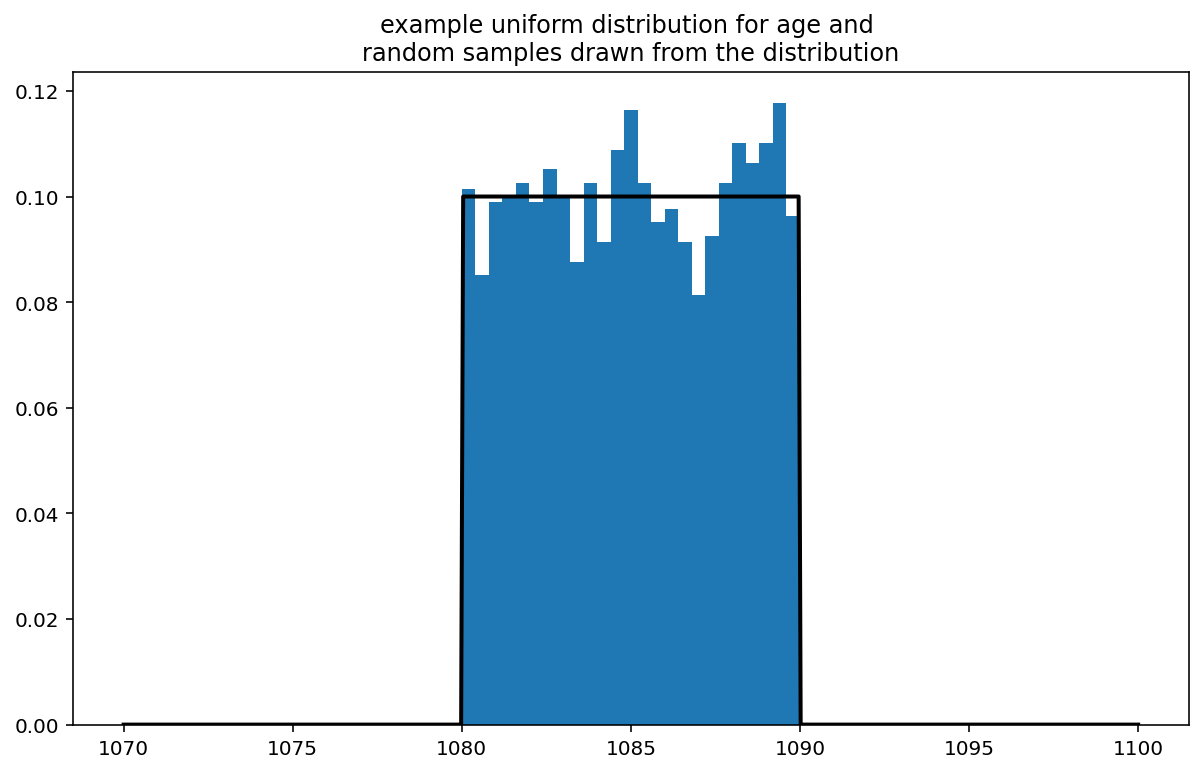

In [17]:
with pm.Model():
    u = 1080
    sigma = 5
    age_lower = 1080
    age_upper = 1090
    
    age = pm.Uniform('U', age_lower, age_upper)
    
    data = np.array([age.random() for i in range(2000)])
    
    x = np.linspace(1070, 1100, 500)
    y = np.zeros(500)
    y[(x<age_upper) & (x>age_lower)] = 1.0/(age_upper-age_lower)
    
    plt.figure(figsize=(10,6))
    plt.plot(x, y, label='lower = {}, upper = {}'.format(age_lower, age_upper), color = 'black', lw=2)
    
    
    plt.hist(data, density=1, bins = 25, color = 'C0')
    plt.title('example uniform distribution for age and \nrandom samples drawn from the distribution')

## Fisher probability densities for distributions of paleomagnetic directional data

Fisher, N. I., Lewis, T., Embleton, B. J., 1987. Statistical analysis of spherical data. Cam- bridge university press.

In [6]:
def fisher_logp(lon_lat, k, x):

    if k == 0:
        return np.log(1. / 4. / np.pi)
    
    theta = pmag.angle(x, lon_lat)[0]
    PdA = k*np.exp(k*np.cos(theta*d2r))/(2*np.pi*(np.exp(k)-np.exp(-k)))
    logp = np.log(PdA)

    return np.array(logp)

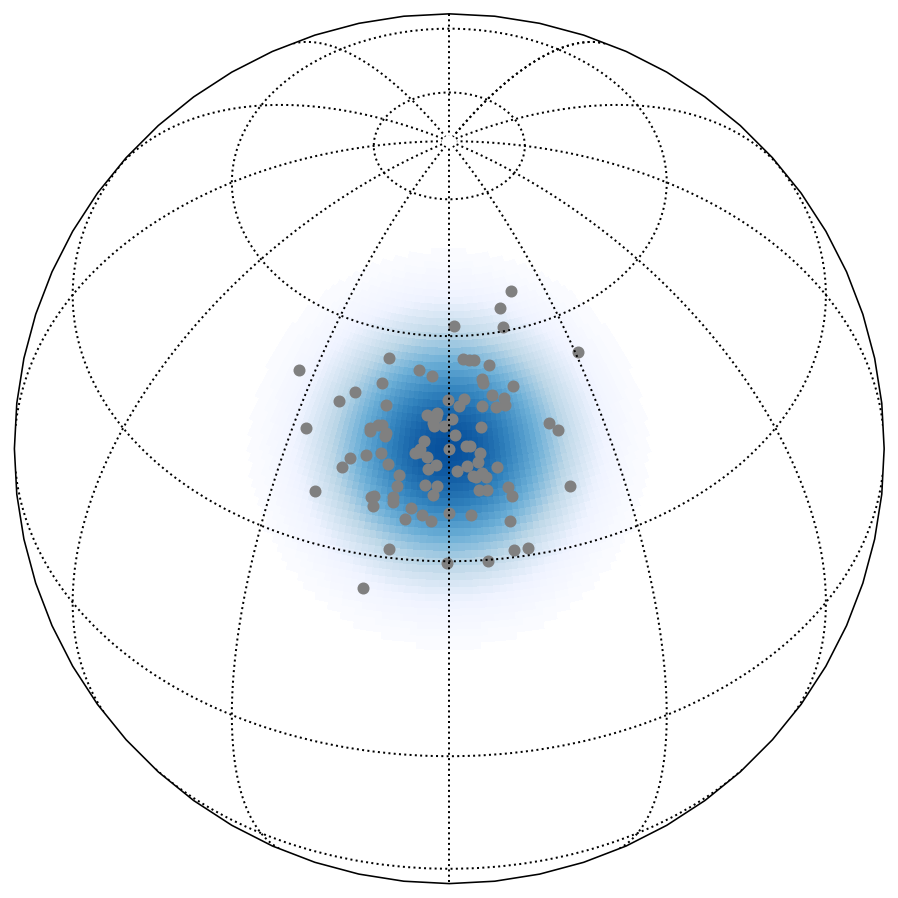

In [19]:
with pm.Model() as model:
    lon = 30.
    lat = 45.
    k = 50.
    vmf = pep.VMF('vmf', lon_lat = [lon, lat], k = k, testval = np.array([1., 0.]), shape = 2)
    data = np.array([vmf.random() for i in range(100)])
    
    for i, this_lat in enumerate(reg_lat):
        for j, this_lon in enumerate(reg_lon):
            fisher_vals[i,j] = np.exp(fisher_logp([lon, lat], k, [this_lon,this_lat]))

    phi = data[:,0]
    theta = data[:,1]

    ax = ipmag.make_orthographic_map(lon, lat)
    c = ax.pcolormesh(mesh_lon,mesh_lat, fisher_vals,  transform=ccrs.PlateCarree(), cmap=cmap_blue, rasterized=1)

    ax.scatter(phi, theta,  25, color = 'grey', marker = 'o', edgecolor='grey', alpha = 1, transform=ccrs.PlateCarree() )
    plt.savefig('code_output/example_fisher_distribution.png',bbox_inches='tight', dpi=300)
    plt.show() 

## Watson girdle probability densities for distributions of Euler pole or true polar wander rotation pole directional data

Watson, G. S. (1965). Equatorial distributions on a sphere. Biometrika, 52(1/2), 193-201.

In [20]:
def girdle_logp(lon_lat, k, x):
    
    if k > 0:
        raise ValueError('k has to be negative!')
        return 
    if k == 0:
        return np.log(1. / 4. / np.pi)
    
    theta = pmag.angle(x, lon_lat)[0]
    pw = 1/sc.hyp1f1(1/2, 3/2, k)/4/np.pi*np.exp(k*np.cos(theta*d2r)**2)
    log_pw = np.log(pw)
    
    return np.array(log_pw)

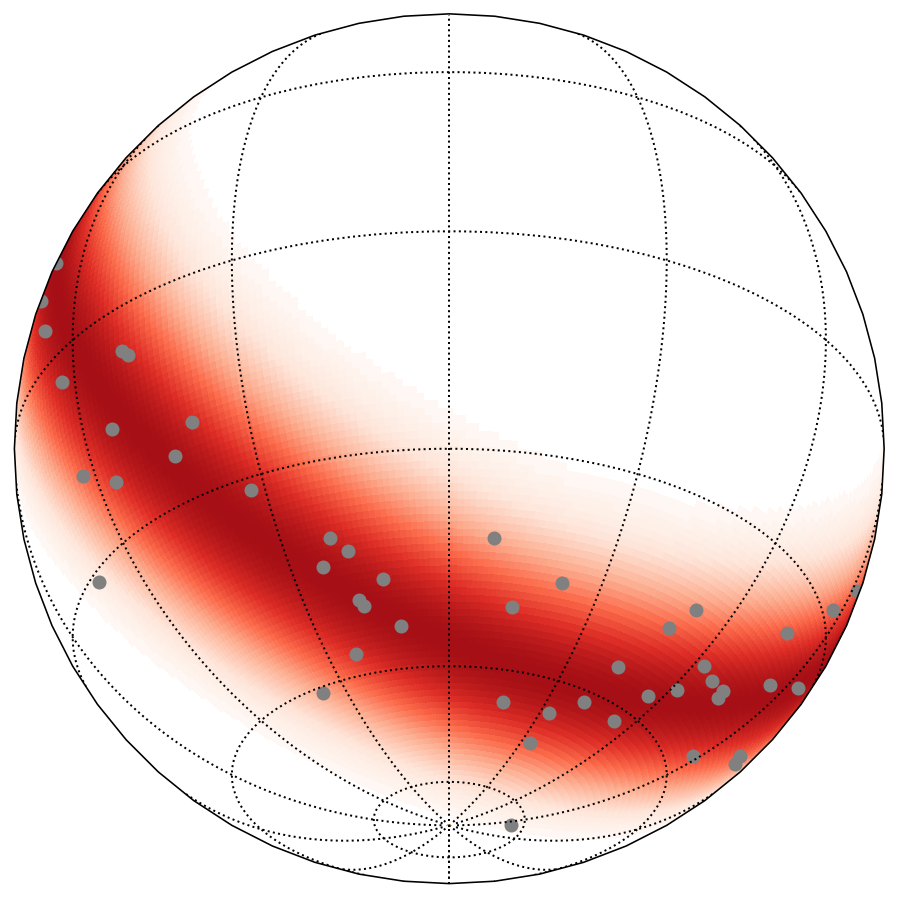

In [21]:
with pm.Model() as model:
    lon = 30.
    lat = 30.
    k = -25.
    WG = pep.Watson_Girdle('WG', lon_lat = [lon, lat], k = k, testval = np.array([1., 0.]), shape = 2)
    data = np.array([WG.random() for i in range(100)])
    
    for i, this_lat in enumerate(reg_lat):
        for j, this_lon in enumerate(reg_lon):
            watson_vals[i,j] = np.exp(girdle_logp([lon, lat], k, [this_lon,this_lat]))
    
    phi = data[:,0]
    theta = data[:,1]

    ax = ipmag.make_orthographic_map(lon-30, lat-60)
    c = ax.pcolormesh(mesh_lon, mesh_lat, watson_vals,  transform=ccrs.PlateCarree(), cmap=cmap_red, rasterized=True)

    ax.scatter(phi, theta,  color = 'grey', marker = 'o', edgecolor='grey', alpha = 1, transform=ccrs.PlateCarree() )
    plt.savefig('code_output/example_girdle_distribution.png',bbox_inches='tight', dpi=300)
    plt.show() 

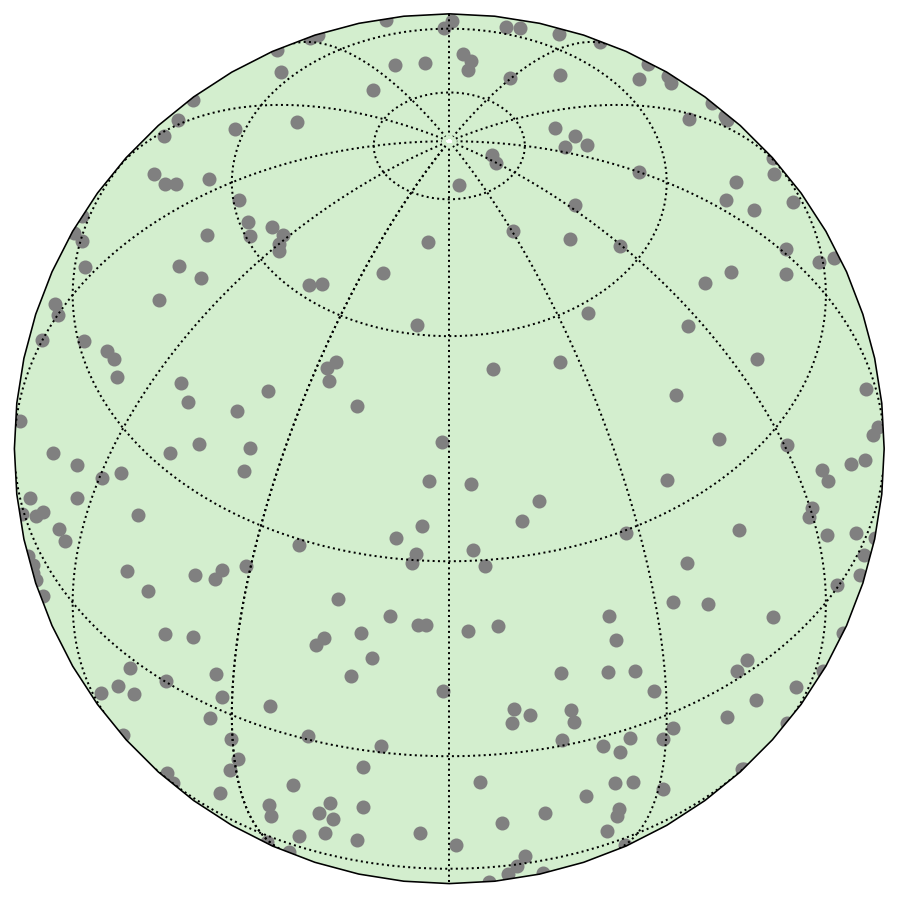

In [22]:
with pm.Model() as model:
    lon = 30.
    lat = 0.
    k = 0.
    # either fisherian or watson girdle distribution can work for uniform spherical distribution
    vmf1 = pep.VMF('U1', lon_lat = [lon, lat], k = k, testval = np.array([1., 0.]), shape = 2)
#     vmf2 = pep.Watson_Girdle('U2', lon_lat = [lon, lat], k = k, testval = np.array([1., 0.]), shape = 2)

    data1 = np.array([vmf1.random() for i in range(500)])
#     data2 = np.array([vmf2.random() for i in range(1000)])
    
    phi1 = data1[:,0]
    theta1 = data1[:,1]
#     phi2 = data2[:,0]
#     theta2 = data2[:,1]
#     for i, this_lat in enumerate(reg_lat):
#         for j, this_lon in enumerate(reg_lon):
#             uniform_vals[i,j] = np.exp(girdle_logp([lon, lat], k, [this_lon,this_lat]))
            
    
    ax = ipmag.make_orthographic_map(lon-180, lat+45)
    c = ax.pcolormesh(mesh_lon, mesh_lat, uniform_vals,  transform=ccrs.PlateCarree(), cmap=cmap_green, vmin=-0.1, vmax=1.0, rasterized=True)
    ax.scatter(phi1, theta1,  color = 'grey', marker = 'o', edgecolor='grey', alpha = 1, transform=ccrs.PlateCarree() )


#     ax.scatter(phi2, theta2,  color = 'r', marker = 's', edgecolor='r', alpha = 0.2, transform=ccrs.PlateCarree() )

#     ipmag.plot_vgp(ax, lon, lat)
    plt.savefig('code_output/example_Sphere_uniform_distribution.png',bbox_inches='tight', dpi=300)
    plt.show() 

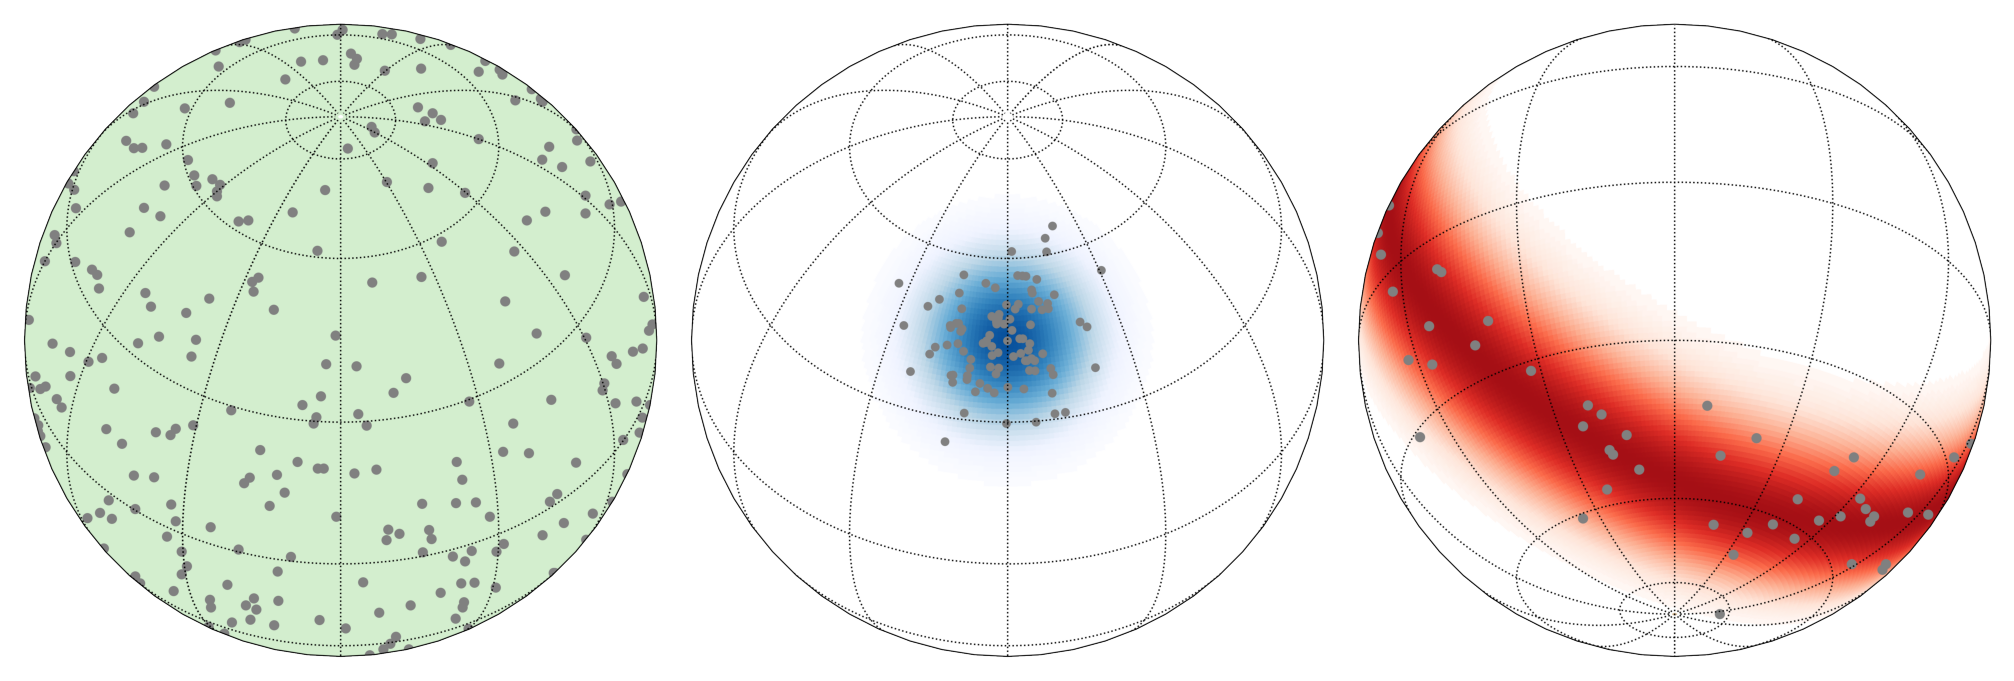

In [32]:
example_uniform = mpimg.imread('code_output/example_Sphere_uniform_distribution.png');
example_fisher = mpimg.imread('code_output/example_fisher_distribution.png');
example_girdle = mpimg.imread('code_output/example_girdle_distribution.png');


fig = plt.figure(figsize=(18,6))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [example_uniform,
                         example_fisher,
                         example_girdle
                         
                         ]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.axis("off")


plt.subplots_adjust(wspace=-5, hspace=-5)

plt.savefig('code_output/example_direction_distributions.png',dpi=300)

plt.show()

## Normal distribution for paleomagnetic poles with good age constraints

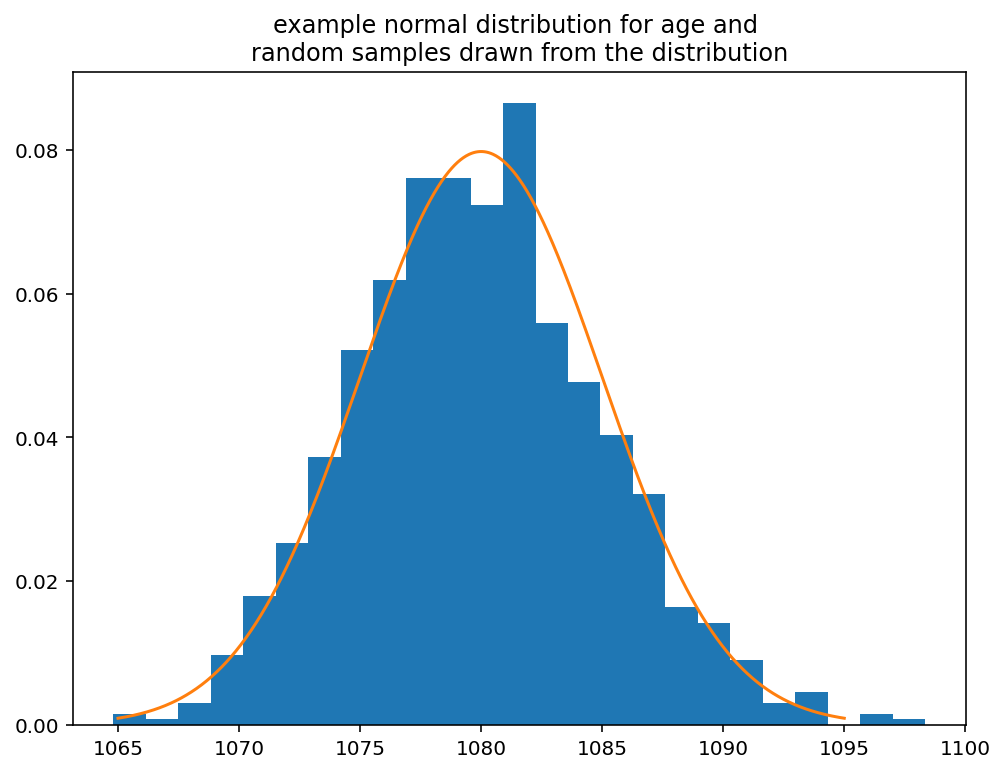

In [10]:
with pm.Model():
    mu = 1080
    sigma = 5
    age = pm.Normal('x', mu=mu, sigma=sigma)
    data = np.array([age.random() for i in range(1000)])
    
    x = np.linspace(mu-3*sigma,mu+3*sigma, 1000)
    
    
    plt.figure(figsize=(8,6))

    pdf = st.norm.pdf(x, mu, sigma)
    
    plt.hist(data, density=1, bins = 25)
    plt.plot(x, pdf, label=r'$\mu$ = {}, $\sigma$ = {}'.format(mu, sigma))
    plt.title('example normal distribution for age and \nrandom samples drawn from the distribution')

## Exponential distribution for Euler pole rotation rate